In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import time  # Important addition

# For GPU memory management (optional)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

class DataPreprocessor:
    def __init__(self, max_length=40, vocab_size=8000, batch_size=64):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.source_texts = []  # Store source texts
        self.target_texts = []  # Store target texts
        
        # Initialize tokenizers
        self.source_tokenizer = tf.keras.layers.TextVectorization(
            max_tokens=self.vocab_size,
            output_mode='int',
            output_sequence_length=self.max_length,
        )
        
        self.target_tokenizer = tf.keras.layers.TextVectorization(
            max_tokens=self.vocab_size,
            output_mode='int',
            output_sequence_length=self.max_length,
        )

    def clean_text(self, text):
        """Basic text cleaning"""
        text = text.strip()
        return text

    def load_data(self, source_path, target_path, sample_size=None):
        """Load and clean the data"""
        print(f"Loading data from {source_path} and {target_path}")
        with open(source_path, 'r', encoding='utf-8') as f:
            self.source_texts = [self.clean_text(line) for line in f.readlines()]
        with open(target_path, 'r', encoding='utf-8') as f:
            self.target_texts = [self.clean_text(line) for line in f.readlines()]
            
        if sample_size:
            indices = np.random.choice(len(self.source_texts), sample_size, replace=False)
            self.source_texts = [self.source_texts[i] for i in indices]
            self.target_texts = [self.target_texts[i] for i in indices]
        
        print(f"Loaded {len(self.source_texts)} sentence pairs")
        return self.source_texts, self.target_texts

    def prepare_data(self, train_source_path, train_target_path, 
                    val_source_path=None, val_target_path=None):
        """Complete data preparation pipeline"""
        # Load training data
        print("Loading and preprocessing training data...")
        train_sources, train_targets = self.load_data(train_source_path, train_target_path)
        
        # Adapt tokenizers
        print("Adapting tokenizers to the data...")
        self.source_tokenizer.adapt(train_sources)
        self.target_tokenizer.adapt(train_targets)
        
        # Create training dataset
        print("Creating training dataset...")
        train_ds = self.create_dataset(train_sources, train_targets)
        
        # Create validation dataset if paths provided
        val_ds = None
        if val_source_path and val_target_path:
            print("Loading and preprocessing validation data...")
            val_sources, val_targets = self.load_data(val_source_path, val_target_path)
            val_ds = self.create_dataset(val_sources, val_targets)
        
        print("Data preparation completed!")
        return train_ds, val_ds
    
    def create_dataset(self, sources, targets):
        """Create a TensorFlow dataset"""
        # Tokenize the data
        source_data = self.source_tokenizer(sources)
        target_data = self.target_tokenizer(targets)
        
        dataset = tf.data.Dataset.from_tensor_slices((
            {
                'encoder_inputs': source_data,
                'decoder_inputs': target_data[:, :-1]
            },
            target_data[:, 1:]
        ))
        
        dataset = dataset.shuffle(len(sources))
        dataset = dataset.batch(self.batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset

    def decode_sequence(self, sequence):
        """Convert number sequence back to text"""
        return self.target_tokenizer.get_vocabulary()[sequence]
    
    @property
    def source_vocab_size(self):
        return len(self.source_tokenizer.get_vocabulary())
    
    @property
    def target_vocab_size(self):
        return len(self.target_tokenizer.get_vocabulary())

# Helper function
def prepare_translation_data(train_en_path, train_ur_path, 
                           val_en_path=None, val_ur_path=None,
                           max_length=40, vocab_size=8000, batch_size=64):
    """Helper function to prepare translation data"""
    
    # Initialize preprocessor
    preprocessor = DataPreprocessor(
        max_length=max_length,
        vocab_size=vocab_size,
        batch_size=batch_size
    )
    
    # Prepare datasets
    train_dataset, val_dataset = preprocessor.prepare_data(
        train_source_path=train_en_path,
        train_target_path=train_ur_path,
        val_source_path=val_en_path,
        val_target_path=val_ur_path
    )
    
    return preprocessor, train_dataset, val_dataset

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
import time

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
        
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights

def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    return output, attention_weights

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        
        return out3, attn_weights_block1, attn_weights_block2

In [3]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        
        # Calculate positional encoding matrix
        pos = np.arange(max_len)[:, np.newaxis]
        angles = np.arange(d_model)[np.newaxis, :] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model)
        
        pos_encoding = np.zeros((max_len, d_model))
        pos_encoding[:, 0::2] = np.sin(pos * angles[:, 0::2])
        pos_encoding[:, 1::2] = np.cos(pos * angles[:, 1::2])
        
        self.pos_encoding = tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)
    
    def call(self, inputs):
        sequence_length = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :sequence_length, :]

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, max_position_encoding, rate=0.1):
        super().__init__()
        
        self.encoder_embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.decoder_embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        
        self.pos_encoding = PositionalEncoding(d_model, max_position_encoding)
        
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate) 
            for _ in range(num_layers)
        ]
        
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate) 
            for _ in range(num_layers)
        ]
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.num_layers = num_layers
        self.d_model = d_model

    def create_padding_mask(self, seq):
        if isinstance(seq, dict):
            seq = seq['encoder_inputs']
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]

    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask

    def call(self, inputs, training=False):
        if isinstance(inputs, dict):
            inp = inputs['encoder_inputs']
            tar = inputs['decoder_inputs']
            if isinstance(inp, dict):
                inp = inp['encoder_inputs']
            if isinstance(tar, dict):
                tar = tar['decoder_inputs']
        else:
            inp, tar = inputs

        enc_padding_mask = self.create_padding_mask(inp)
        dec_padding_mask = self.create_padding_mask(inp)
        
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(tar)[1])
        dec_target_padding_mask = self.create_padding_mask(tar)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        
        # Encoder
        enc_output = self.encoder_embedding(inp)
        enc_output *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        enc_output = self.pos_encoding(enc_output)
        enc_output = self.dropout(enc_output, training=training)
        
        for i in range(self.num_layers):
            enc_output = self.encoder_layers[i](
                enc_output, training=training, mask=enc_padding_mask)
        
        # Decoder
        dec_output = self.decoder_embedding(tar)
        dec_output *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        dec_output = self.pos_encoding(dec_output)
        dec_output = self.dropout(dec_output, training=training)
        
        for i in range(self.num_layers):
            dec_output, _, _ = self.decoder_layers[i](
                dec_output, enc_output, training=training,
                look_ahead_mask=combined_mask,
                padding_mask=dec_padding_mask)
        
        final_output = self.final_layer(dec_output)
        return final_output

    def build(self, input_shape):
        super().build(input_shape)

In [4]:
# First add the imports at the top if not already present
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import time
import traceback

# Custom Learning Rate Schedule
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps,
        }

class TransformerTrainer:
    def __init__(self, transformer, preprocessor, d_model):
        self.transformer = transformer
        self.preprocessor = preprocessor
        
        # Learning rate scheduler and optimizer
        self.learning_rate = CustomSchedule(d_model)
        self.optimizer = tf.keras.optimizers.Adam(
            self.learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
        )
        
        # Fix: Initialize metrics with keras.metrics
        self.train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
        self.val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
        self.val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('val_accuracy')
        
        # Training history
        self.history = {
            'train_loss': [], 
            'train_accuracy': [],
            'val_loss': [], 
            'val_accuracy': [], 
            'bleu_scores': []
        }

    def loss_function(self, real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, 0))
        loss_ = tf.keras.losses.sparse_categorical_crossentropy(
            real, pred, from_logits=True)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

    @tf.function
    def train_step(self, inp, tar):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]
        
        with tf.GradientTape() as tape:
            predictions = self.transformer(
                {
                    'encoder_inputs': inp, 
                    'decoder_inputs': tar_inp
                }, 
                training=True
            )
            loss = self.loss_function(tar_real, predictions)

        gradients = tape.gradient(loss, self.transformer.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.transformer.trainable_variables))
        
        self.train_loss(loss)
        self.train_accuracy(tar_real, predictions)
        
        return loss

    def validation_step(self, inp, tar):
        tar_inp = tar[:, :-1]
        tar_real = tar[:, 1:]
        
        predictions = self.transformer(
            {
                'encoder_inputs': inp, 
                'decoder_inputs': tar_inp
            }, 
            training=False
        )
        loss = self.loss_function(tar_real, predictions)
        
        self.val_loss(loss)
        self.val_accuracy(tar_real, predictions)
        
        return loss

    def train(self, train_dataset, val_dataset, epochs=50):
        best_val_loss = float('inf')
        patience = 5
        patience_counter = 0
        
        for epoch in range(epochs):
            start = time.time()
            
            # Reset metrics
            self.train_loss.reset_state()
            self.train_accuracy.reset_state()
            self.val_loss.reset_state()
            self.val_accuracy.reset_state()
            
            print(f'\nEpoch {epoch + 1}/{epochs}')
            
            # Training loop
            for batch, (inp, tar) in enumerate(train_dataset):
                loss = self.train_step(inp, tar)
                
                if batch % 50 == 0:
                    print(f'Batch {batch} Loss {self.train_loss.result():.4f} '
                          f'Accuracy {self.train_accuracy.result():.4f}')
            
            # Validation loop
            for (inp, tar) in val_dataset:
                self.validation_step(inp, tar)
            
            # Store metrics
            self.history['train_loss'].append(float(self.train_loss.result()))
            self.history['train_accuracy'].append(float(self.train_accuracy.result()))
            self.history['val_loss'].append(float(self.val_loss.result()))
            self.history['val_accuracy'].append(float(self.val_accuracy.result()))
            
            # Print epoch results
            print(f'\nEpoch {epoch + 1} Results:')
            print(f'Time taken: {time.time() - start:.2f} secs')
            print(f'Train Loss: {self.train_loss.result():.4f}')
            print(f'Train Accuracy: {self.train_accuracy.result():.4f}')
            print(f'Validation Loss: {self.val_loss.result():.4f}')
            print(f'Validation Accuracy: {self.val_accuracy.result():.4f}')
            
            # Calculate BLEU score
            try:
                bleu = self.calculate_bleu_score(val_dataset)
                self.history['bleu_scores'].append(bleu)
                print(f'BLEU Score: {bleu:.4f}')
            except Exception as e:
                print(f'BLEU Score calculation failed: {str(e)}')
                self.history['bleu_scores'].append(0.0)
            
            # Early stopping and model saving
            val_loss = float(self.val_loss.result())
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                self.transformer.save_weights('best_transformer.weights.h5')
                print("Model saved!")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered!")
                    break
        
        return self.history

    def translate(self, sentence):
        # Preprocess input
        encoder_input = self.preprocessor.source_tokenizer([sentence])
        
        # Initialize decoder input
        decoder_input = tf.zeros((1, 1), dtype=tf.int64)
        output = []
        
        for i in range(self.preprocessor.max_length):
            predictions = self.transformer(
                {
                    'encoder_inputs': encoder_input,
                    'decoder_inputs': decoder_input
                },
                training=False
            )
            
            # Get next token prediction
            predictions = predictions[:, -1:, :]
            predicted_id = tf.argmax(predictions, axis=-1)
            
            if predicted_id == 0:  # Stop if end token is predicted
                break
                
            output.append(predicted_id[0])
            decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)
        
        # Convert to text
        output = tf.concat(output, axis=0).numpy()
        translated_text = ' '.join([
            self.preprocessor.target_tokenizer.get_vocabulary()[i] 
            for i in output
        ])
        
        return translated_text

    def calculate_bleu_score(self, dataset, num_examples=10):
        """Calculate BLEU score with proper error handling"""
        try:
            references = []
            hypotheses = []
            
            # Get a batch of data
            for i, (inp, tar) in enumerate(dataset.take(num_examples)):
                # Get source text from input tensor
                source_text = ''
                if isinstance(inp, dict):
                    input_tensor = inp['encoder_inputs']
                else:
                    input_tensor = inp
                    
                # Convert to numpy for easier processing
                input_array = input_tensor.numpy()[0]  # Get first sequence in batch
                target_array = tar.numpy()[0]  # Get first sequence in batch
                
                # Process source text
                for token_id in input_array:
                    if token_id != 0:  # Skip padding
                        word = self.preprocessor.source_tokenizer.get_vocabulary()[token_id]
                        source_text += word + ' '
                source_text = source_text.strip()
                
                # Process target/reference text
                reference = ''
                for token_id in target_array:
                    if token_id != 0:  # Skip padding
                        word = self.preprocessor.target_tokenizer.get_vocabulary()[token_id]
                        reference += word + ' '
                reference = reference.strip()
                
                # Get translation
                translation = self.translate(source_text)
                
                # Add to BLEU calculation lists
                references.append([reference.split()])
                hypotheses.append(translation.split())
                
                # Print examples for debugging
                if i < 2:
                    print(f"\nExample {i+1}:")
                    print(f"Source: {source_text}")
                    print(f"Reference: {reference}")
                    print(f"Translation: {translation}")
            
            # Calculate BLEU score with smoothing
            smoothing = SmoothingFunction().method1
            weights = (0.25, 0.25, 0.25, 0.25)
            bleu_score = corpus_bleu(
                references, 
                hypotheses,
                weights=weights,
                smoothing_function=smoothing
            )
            
            return float(bleu_score)
        except Exception as e:
            print(f"BLEU Score Calculation Error: {str(e)}")
            print(traceback.format_exc())
            return 0.0

    def plot_history(self):
        plt.figure(figsize=(15, 5))
        
        # Plot loss
        plt.subplot(1, 3, 1)
        plt.plot(self.history['train_loss'], label='Train')
        plt.plot(self.history['val_loss'], label='Validation')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        # Plot accuracy
        plt.subplot(1, 3, 2)
        plt.plot(self.history['train_accuracy'], label='Train')
        plt.plot(self.history['val_accuracy'], label='Validation')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        
        # Plot BLEU scores
        if self.history['bleu_scores']:
            plt.subplot(1, 3, 3)
            plt.plot(self.history['bleu_scores'])
            plt.title('BLEU Score')
            plt.xlabel('Epoch')
        
        plt.tight_layout()
        plt.show()

Loading and preprocessing data...
Loading and preprocessing training data...
Loading data from quran/train.en and quran/train.ur
Loaded 6000 sentence pairs
Adapting tokenizers to the data...
Creating training dataset...
Loading and preprocessing validation data...
Loading data from quran/test.en and quran/test.ur
Loaded 200 sentence pairs
Data preparation completed!
Source vocabulary size: 7932
Target vocabulary size: 7154

Initializing Transformer model...
Setting up trainer...

Starting training...

Epoch 1/100
Batch 0 Loss 8.9103 Accuracy 0.0000
Batch 50 Loss 8.8465 Accuracy 0.0010

Epoch 1 Results:
Time taken: 124.14 secs
Train Loss: 8.7543
Train Accuracy: 0.0106
Validation Loss: 8.5188
Validation Accuracy: 0.0110

Example 1:
Source: again you are warned no never you will soon learn about your end
Reference: آگاہ کیا جاتا ہے ہرگز نہیں عنقریب تمہیں اپنا انجام معلوم ہو جائے گا ۔
Translation: اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور اور ا

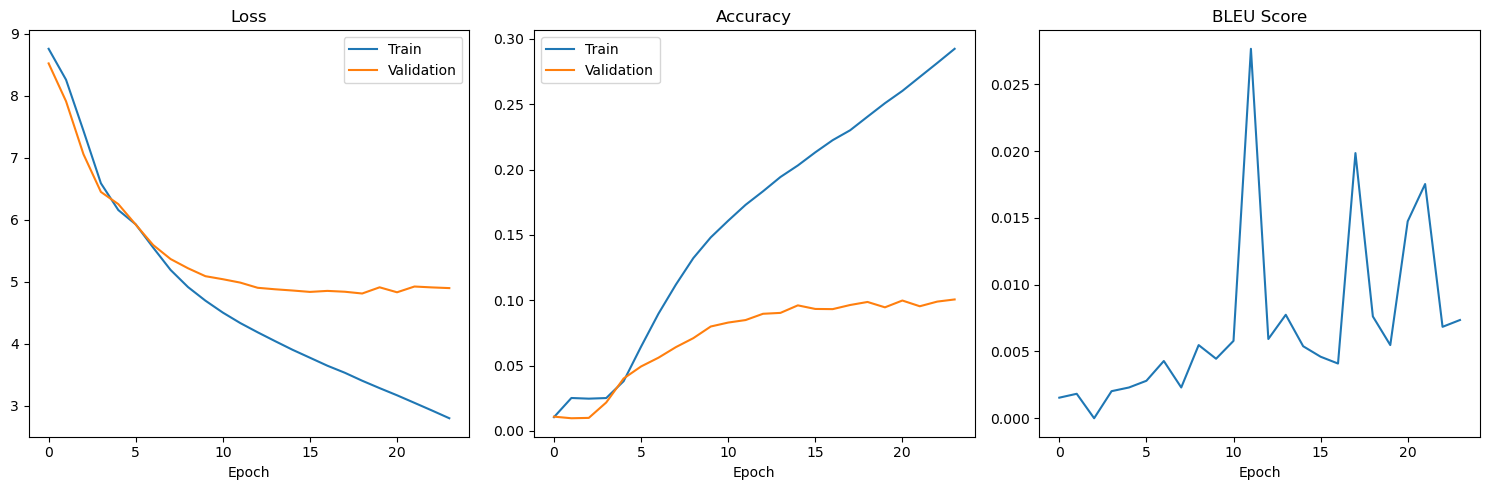


Testing translations...

Test Translations:

English: The cat sits on the mat
Urdu: جھٹلانے والوں کے لئے خرابی ہے ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
------------------------------

English: I love reading books
Urdu: تم میں سے ۔ بیشک میں سے ہے ۔ ۔ تم ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
------------------------------

English: What is your name?
Urdu: کے لئے ۔ یہ ہے ۔ ۔ تم سب کے ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
------------------------------

English: How are you doing today?
Urdu: تم سے نکالے جاؤ ۔ بیشک تم شکر گزار ہو ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
------------------------------

English: The weather is beautiful
Urdu: کے لئے اور ۔ سب کے لئے ہے ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔ ۔
------------------------------

Calculating final BLEU score...

Example 1:
Source: who is the king of all mankind
Reference: سب لوگوں کا بادشاہ ہے ۔
Translation: کے لئے ب

In [5]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Model parameters
MAX_LENGTH = 40
VOCAB_SIZE = 8000
BATCH_SIZE = 64
NUM_LAYERS = 4
D_MODEL = 128
NUM_HEADS = 8
DFF = 512
DROPOUT_RATE = 0.1
EPOCHS = 100

try:
    # Data preprocessing
    print("Loading and preprocessing data...")
    preprocessor = DataPreprocessor(
        max_length=MAX_LENGTH,
        vocab_size=VOCAB_SIZE,
        batch_size=BATCH_SIZE
    )

    # Load and prepare datasets
    train_dataset, val_dataset = preprocessor.prepare_data(
        train_source_path='quran/train.en',
        train_target_path='quran/train.ur',
        val_source_path='quran/test.en',
        val_target_path='quran/test.ur'
    )

    print(f"Source vocabulary size: {preprocessor.source_vocab_size}")
    print(f"Target vocabulary size: {preprocessor.target_vocab_size}")

    # Initialize Transformer model
    print("\nInitializing Transformer model...")
    transformer = Transformer(
        num_layers=NUM_LAYERS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dff=DFF,
        input_vocab_size=preprocessor.source_vocab_size,
        target_vocab_size=preprocessor.target_vocab_size,
        max_position_encoding=MAX_LENGTH,
        rate=DROPOUT_RATE
    )

    # Initialize trainer
    print("Setting up trainer...")
    trainer = TransformerTrainer(
        transformer=transformer,
        preprocessor=preprocessor,
        d_model=D_MODEL
    )

    # Train the model
    print("\nStarting training...")
    history = trainer.train(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        epochs=EPOCHS
    )
    
    # Save the final model
    transformer.save_weights('final_transformer.weights.h5')
    print("\nTraining completed and model saved!")
    
    # Plot training history
    trainer.plot_history()
    
    # Test some translations
    print("\nTesting translations...")
    test_sentences = [
        "The cat sits on the mat",
        "I love reading books",
        "What is your name?",
        "How are you doing today?",
        "The weather is beautiful"
    ]

    print("\nTest Translations:")
    print("=" * 50)
    for sentence in test_sentences:
        translation = trainer.translate(sentence)
        print(f"\nEnglish: {sentence}")
        print(f"Urdu: {translation}")
        print("-" * 30)

    # Calculate final BLEU score
    print("\nCalculating final BLEU score...")
    final_bleu = trainer.calculate_bleu_score(val_dataset)
    print(f"Final BLEU Score: {final_bleu:.4f}")

except KeyboardInterrupt:
    print("\nTraining interrupted by user.")
    # Save the model even if interrupted
    transformer.save_weights('interrupted_transformer.weights.h5')
    print("Model saved!")

except Exception as e:
    print(f"\nAn error occurred: {str(e)}")
    print("Please check the error message above.")

finally:
    # Final summary regardless of how training ended
    if 'history' in locals():
        print("\nTraining Summary")
        print("=" * 50)
        if len(history['train_loss']) > 0:
            print(f"Best Training Loss: {min(history['train_loss']):.4f}")
            print(f"Best Training Accuracy: {max(history['train_accuracy']):.4f}")
            print(f"Best Validation Loss: {min(history['val_loss']):.4f}")
            print(f"Best Validation Accuracy: {max(history['val_accuracy']):.4f}")
            if history['bleu_scores']:
                print(f"Best BLEU Score: {max(history['bleu_scores']):.4f}")